# Exercise Sheet 5

Dominique Cheray, Manuel Krämer

## 2.

In [1]:
import sys
import argparse
from scipy.misc import imread, imsave
import numpy
import time
import scipy.sparse
import scipy.sparse.linalg
import scipy.spatial

def gaussian_kernel(data, sigma, max_distance, rho, gamma):
    """Compute the gaussian kernel matrix.

    :param data: data matrix
    :param sigma: parameter sigma of the gaussian kernel
    :return: gaussian kernel matrix
    """
    rho = rho
    gamma = gamma
    
    assert len(data.shape) == 2
    assert sigma > 0

    factor = -0.5 /  (sigma ** 2)
    limit = numpy.exp(factor*max_distance**2)
    # Find the pairwise squared distances and compute the Gaussian kernel.
    K = []
    for k in data:
        d = numpy.exp(-(numpy.sum((data - k)**2,axis=1)/rho**2)**(gamma/2))
        d[d < limit] = 0.0  # truncate the Gaussian
        d = scipy.sparse.csc_matrix(d[:,None])
        K.append(d)
    K = scipy.sparse.hstack(K)
    return K

def compute_alpha(train_x, train_y, tau, sigma, max_distance, rho, gamma):
    """Compute the alpha vector of the ridge regressor.

    :param train_x: training x data
    :param train_y: training y data
    :param tau: parameter tau of the ridge regressor
    :param sigma: parameter sigma of the gaussian kernel
    :return: alpha vector
    """
    print("building input kernel matrix")
    K = gaussian_kernel(train_x, sigma, max_distance, rho, gamma)
    print("sparsity: {:.3f}".format(float(100*K.nnz) / (K.shape[0]*K.shape[1])))
    M = K + tau * scipy.sparse.identity(train_x.shape[0])
    y = scipy.sparse.csc_matrix(train_y[:,None])
    print("solving sparse system")
    alpha = scipy.sparse.linalg.cg(M, train_y)
    print("done computing alpha")
    return alpha[0]

class KernelRidgeRegressor(object):
    """Kernel Ridge Regressor.
    """

    def __init__(self, tau, sigma, rho, gamma):
        self.dim = None
        self.train_x = None
        self.alpha = None
        self.mean_y = None
        self.std_y = None
        self.tau = tau
        self.sigma = sigma
        self.scale = -0.5 / sigma**2
        self.max_distance = 4.0*sigma
        self.rho = rho
        self.gamma = gamma

    def train(self, train_x, train_y):
        """Train the kernel ridge regressor.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert len(train_x.shape) == 2
        assert len(train_y.shape) == 1
        assert train_x.shape[0] == train_y.shape[0]

        self.dim = train_x.shape[1]
        self.train_x = train_x.astype(numpy.float32)
        self.tree = scipy.spatial.cKDTree(self.train_x)

        self.mean_y = train_y.mean()
        self.std_y = train_y.std()
        train_y_std = (train_y - self.mean_y) / self.std_y

        self.alpha = compute_alpha(self.train_x, train_y_std, self.tau, self.sigma, self.max_distance, self.rho, self.gamma)


    def predict_single(self, pred_x):
        """Predict the value of a single instance.

        :param pred_x: x data
        :return: predicted value of pred_x
        """
        assert len(pred_x.shape) == 1
        assert pred_x.shape[0] == self.dim
        #print("pred_x",pred_x)
        indices = numpy.asarray(self.tree.query_ball_point(pred_x, self.max_distance))
        #print(self.tree.query_ball_point(pred_x, self.max_distance))
        dist = numpy.sum((self.train_x[indices]-pred_x)**2, axis=1)
        kappa = numpy.exp(self.scale*dist)
        pred_y = numpy.dot(kappa, self.alpha[indices])
        return self.std_y * pred_y + self.mean_y

    def predict(self, pred_x):
        """Predict the values of pred_x.

        :param pred_x: x data
        :return: predicted values of pred_x
        """
        assert len(pred_x.shape) == 2
        assert pred_x.shape[1] == self.dim
        pred_x = pred_x.astype(numpy.float32)
        return numpy.array([self.predict_single(x) for x in pred_x])


def kernel_ridge_regression(tau, sigma, rho, gamma):
    # Load the image.
    im_orig = numpy.squeeze(imread("cc_90.png"))

    # Make a copy, so both the original and the regressed image can be shown afterwards.
    im = numpy.array(im_orig)

    # Find the known pixels and the pixels that shall be predicted.
    known_ind = numpy.where(im != 0)
    unknown_ind = numpy.where(im == 0)
    known_x = numpy.array(known_ind).transpose()
    known_y = numpy.array(im[known_ind])
    pred_x = numpy.array(unknown_ind).transpose()

    # Train and predict with the given regressor.
    start = time.time()
    print("training...")
    r = KernelRidgeRegressor(tau, sigma, rho, gamma)
    r.train(known_x, known_y)
    print("done training")
    # pickle.dump(r, open("regressor.p", "wb"))
    # r = pickle.load(open("regressor.p", "rb"))
    print("predicting...")
    pred_y = r.predict(pred_x)
    print("done predicting")

    # Write the predicted values back into the image and show the result.
    im[unknown_ind] = pred_y
    stop = time.time()
    print("Train and predict took {:.3f} seconds.".format(stop-start))
    print(im.shape)
    imsave("res.png", im)
    return im

def process_command_line():
    """Parse the command line arguments.
    """
    parser = argparse.ArgumentParser(description="Machine Learning exercise 5.",
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument("-t", "--tau", type=float, default=0.3,
                        help="parameter tau for ridge regression")
    parser.add_argument("-s", "--sigma", type=float, default=4.0,
                        help="parameter sigma of the gaussians")
    
    return parser.parse_args()


def main():
    """Call the exercises.
    """
    # Read the command line arguments.
    #args = process_command_line()
    kernel_ridge_regression(0.8, 2, 3.0, 1.0)
    return 0


if __name__ == "__main__":
    status = main()
    sys.exit(status)


C:\Users\Manuel\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


training...
building input kernel matrix
sparsity: 1.982
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 4.466 seconds.
(338, 250)


C:\Users\Manuel\Anaconda3\lib\site-packages\ipykernel_launcher.py:151: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


SystemExit: 0

C:\Users\Manuel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Text(0.5,1,'corrupted image')

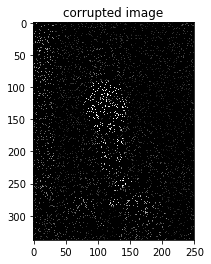

In [3]:
import matplotlib.pyplot as plt

plt.imshow(plt.imread("cc_90.png"), cmap="gray")
plt.title("corrupted image")

Text(0.5,1,'reconstructed image')

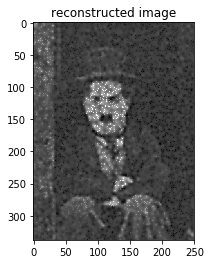

In [4]:
plt.imshow(plt.imread("res.png"), cmap="gray")
plt.title("reconstructed image")

Text(0.5,1,'original image')

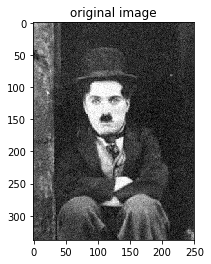

In [5]:
plt.imshow(plt.imread("charlie-chaplin.jpg"), cmap="gray")
plt.title("original image")

The inverse is computed by using conjugate gradient iteration. This solves the equation $(K + \tau*1\!\!1)D = y$ for D

All computations are made with a sparse datastructure which is a good choice because many entries of the Kernel matrix are zero.